In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
plt.style.use('dark_background')

## Modelo LSTM

In [ ]:
#Datos

df=pd.read_excel("/content/PBN.xlsx", usecols=["datetime","precio_bolsa"], sheet_name='2015')

df["datetime"]=pd.to_datetime(df["datetime"])

df.head()

,datetime,precio_bolsa
0,2015-01-01,184.210108
1,2015-01-01,178.210108
2,2015-01-01,178.210108
3,2015-01-01,178.210108
4,2015-01-01,178.210108


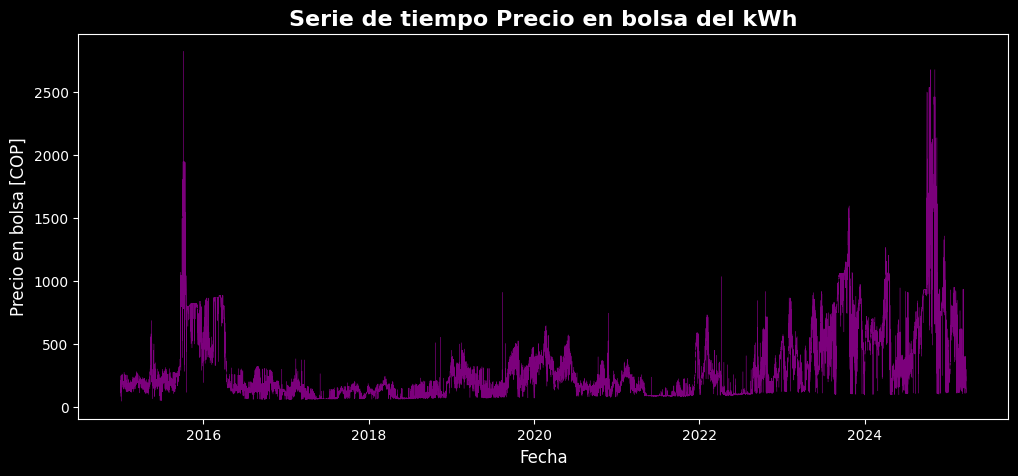

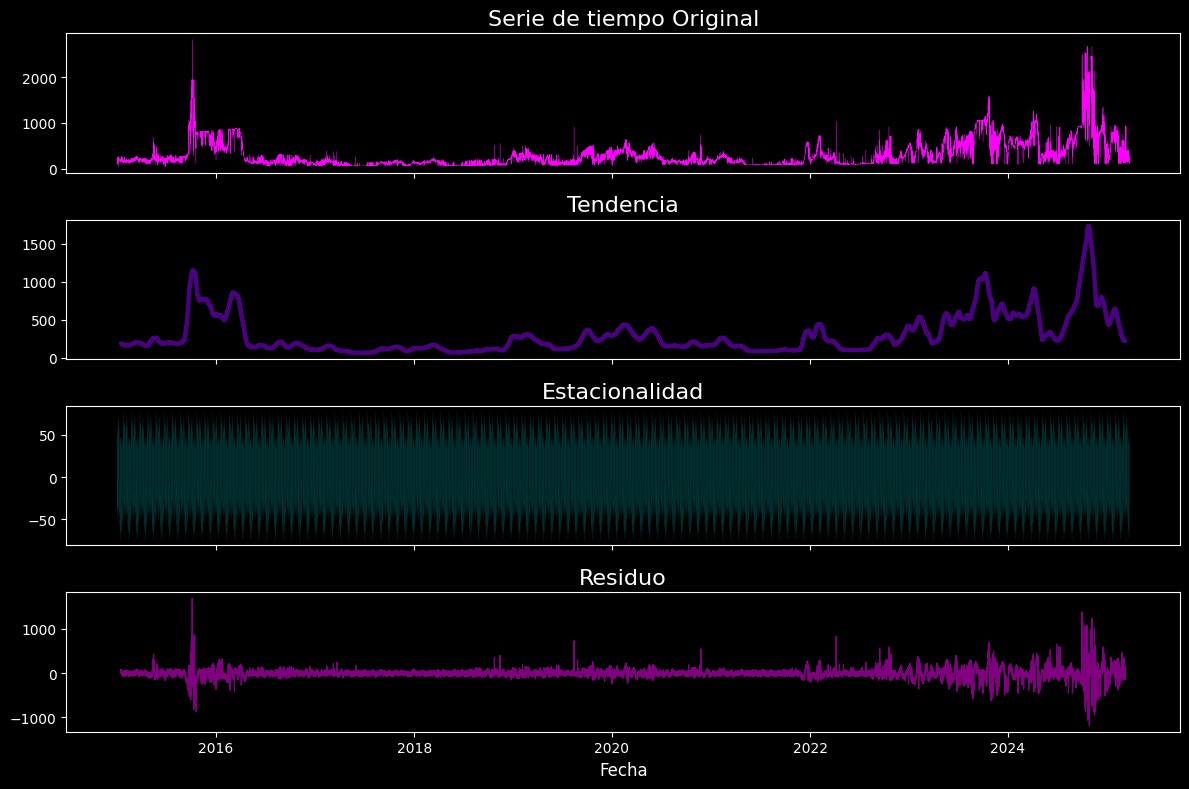

In [ ]:
#Gráficos de la serie de tiempo y sus componentes
plt.figure(figsize=(12,5))
plt.plot(df["datetime"],df["precio_bolsa"],label="Precio de Bolsa",color="darkmagenta",alpha=0.9, linewidth=0.25)
plt.xlabel("Fecha",fontsize=12)
plt.ylabel("Precio en bolsa [COP]",fontsize=12)
plt.title("Serie de tiempo Precio en bolsa del kWh",fontsize=16, fontweight='bold')
plt.show()


#Descomposición de la serie de tiempo
df.set_index("datetime",inplace=True)
decomposicion=sm.tsa.seasonal_decompose(df["precio_bolsa"],model="additive",period=24*30)

fig, axes=plt.subplots(4,1,figsize=(12,8),sharex=True)
axes[0].plot(df["precio_bolsa"],label="Serie Original", color='magenta', linewidth=0.2)
axes[0].set_title("Serie de tiempo Original",fontsize=16)
axes[1].plot(decomposicion.trend,label="Tendencia",color="indigo", linewidth=3)
axes[1].set_title("Tendencia",fontsize=16)
axes[2].plot(decomposicion.seasonal,label="Estacionalidad",color="darkturquoise", linewidth=0.02)
axes[2].set_title("Estacionalidad",fontsize=16)
axes[3].plot(decomposicion.resid,label="Residuo",color="purple", linewidth=0.8)
axes[3].set_title("Residuo",fontsize=16)
plt.xlabel("Fecha",fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-6-8974694c36d3>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


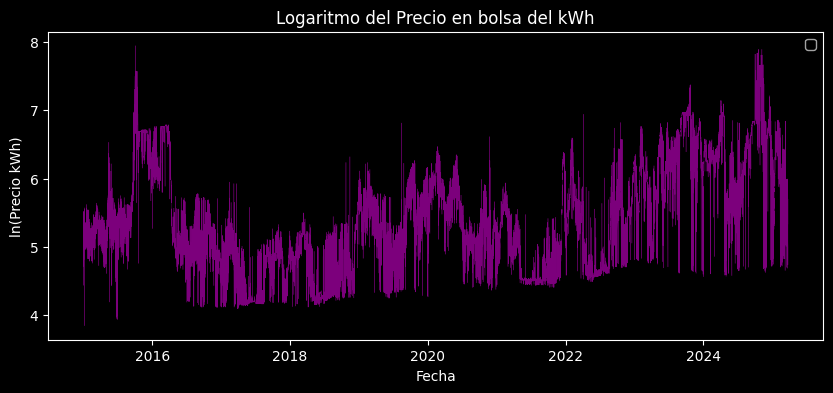

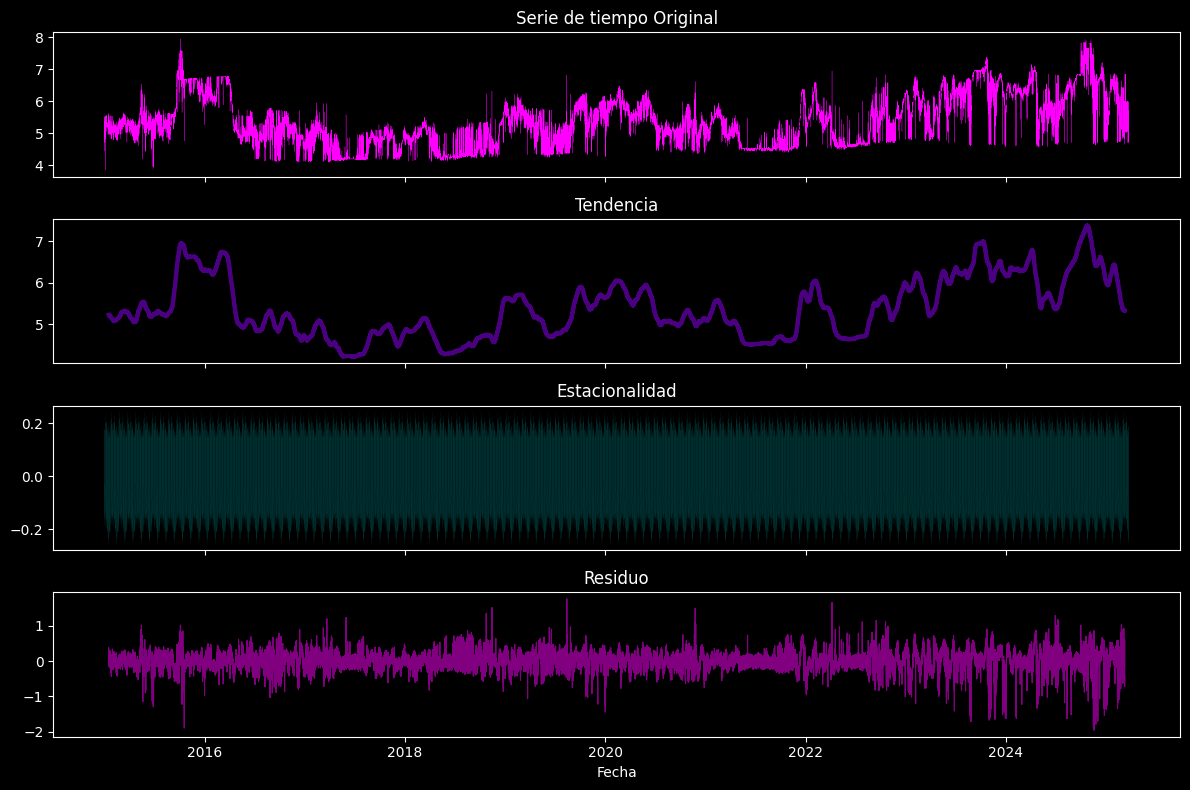

In [ ]:
#Transformación logarítmica y descomposición
df['log_precio_bolsa'] = np.log(df["precio_bolsa"]) #Transformación de los datos
data = df['log_precio_bolsa'].values

# Gráfico de la serie logarítmica
plt.figure(figsize=(10,4))
plt.plot(df.index, df["log_precio_bolsa"],color="darkmagenta",alpha=0.9, linewidth=0.25)
plt.xlabel("Fecha")
plt.ylabel("ln(Precio kWh)")
plt.title("Logaritmo del Precio en bolsa del kWh")
plt.legend()
plt.show()

#Descomposición de la serie de tiempo
decomposicion=sm.tsa.seasonal_decompose(df["log_precio_bolsa"],model="additive",period=24*30)

fig, axes=plt.subplots(4,1,figsize=(12,8),sharex=True)
axes[0].plot(df["log_precio_bolsa"],label="Serie Original", color='magenta', linewidth=0.2)
axes[0].set_title("Serie de tiempo Original")
axes[1].plot(decomposicion.trend,label="Tendencia",color="indigo", linewidth=3)
axes[1].set_title("Tendencia")
axes[2].plot(decomposicion.seasonal,label="Estacionalidad",color="darkturquoise", linewidth=0.02)
axes[2].set_title("Estacionalidad")
axes[3].plot(decomposicion.resid,label="Residuo",color="purple", linewidth=0.8)
axes[3].set_title("Residuo")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

In [ ]:
#Modelo LSTM

data = df['log_precio_bolsa'][:-48].values

pasos_tiempo = 24

# Generar secuencias de datos
def crear_secuencias(datos,pasos_tiempo):
    X,y=[],[]
    for i in range(len(datos)-pasos_tiempo):
        X.append(datos[i:i+pasos_tiempo])
        y.append(datos[i+pasos_tiempo])
    return np.array(X),np.array(y)

escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(data.reshape(-1,1))

X,y = crear_secuencias(datos_escalados,pasos_tiempo)

tscv = TimeSeriesSplit(n_splits=5)

# Generar las divisiones
splits = list(tscv.split(X))

train_idx, test_idx = splits[-1]

X_entreno, X_val = X[train_idx], X[test_idx]
y_entreno, y_val = y[train_idx], y[test_idx]


# Red LSTM
modelo = Sequential([
    LSTM(36,return_sequences=True,activation="tanh",recurrent_activation="sigmoid",kernel_regularizer=l2(0.012),input_shape=(pasos_tiempo,1)),
    BatchNormalization(),
    Dropout(0.23),
    LSTM(36,return_sequences=False,activation="tanh",recurrent_activation="sigmoid",kernel_regularizer=l2(0.012)),
    BatchNormalization(),
    Dropout(0.23),
    Dense(24,activation="tanh",kernel_regularizer=l2(0.012)),
    Dense(1,activation="linear")
])

optimizador = Adam(learning_rate=0.00005)
modelo.compile(optimizer=optimizador,loss="mse",metrics=["mae"])

parada_temprana = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

historial = modelo.fit(X_entreno,y_entreno,epochs=40,batch_size=256,validation_data=(X_val,y_val),verbose=1,callbacks=[parada_temprana])

#Predicciones y métricas
y_pred = modelo.predict(X_val)
mse = mean_squared_error(y_val,y_pred)
mae = mean_absolute_error(y_val,y_pred)
r2 = r2_score(y_val,y_pred)

print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Error absoluto medio (MAE): {mae:.6f}")
print(f"Coeficiente de determinación (R²): {r2:.6f}")

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step - loss: 1.3786 - mae: 0.4516 - val_loss: 1.0500 - val_mae: 0.2621
Epoch 2/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 1.0682 - mae: 0.2826 - val_loss: 0.9367 - val_mae: 0.2640
Epoch 3/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 0.9113 - mae: 0.2233 - val_loss: 0.7722 - val_mae: 0.1144
Epoch 4/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - loss: 0.7869 - mae: 0.1868 - val_loss: 0.6716 - val_mae: 0.0800
Epoch 5/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.6815 - mae: 0.1632 - val_loss: 0.5842 - val_mae: 0.0734
Epoch 6/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 0.5882 - mae: 0.1443 - val_loss: 0.5057 - val_mae: 0.0662
Epoch 7/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.5057 - mae: 0.1276 - val_loss: 0.4360 - val_mae: 0.0609
Epoch 8/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - loss: 0.4338 - mae: 0.1136 - val_loss: 0.3744 - val_mae: 0.0550
Epoch 9/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/st

In [ ]:
modelo.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 24, 36)              │           5,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 24, 36)              │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 24, 36)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 36)                  │          10,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 36)                  │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 24)                  │             888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 17,041 (66.57 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 34,084 (133.14 KB)

In [ ]:
# .h5
modelo.save('modelo_lstm.h5')

In [ ]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model('modelo_lstm.h5')

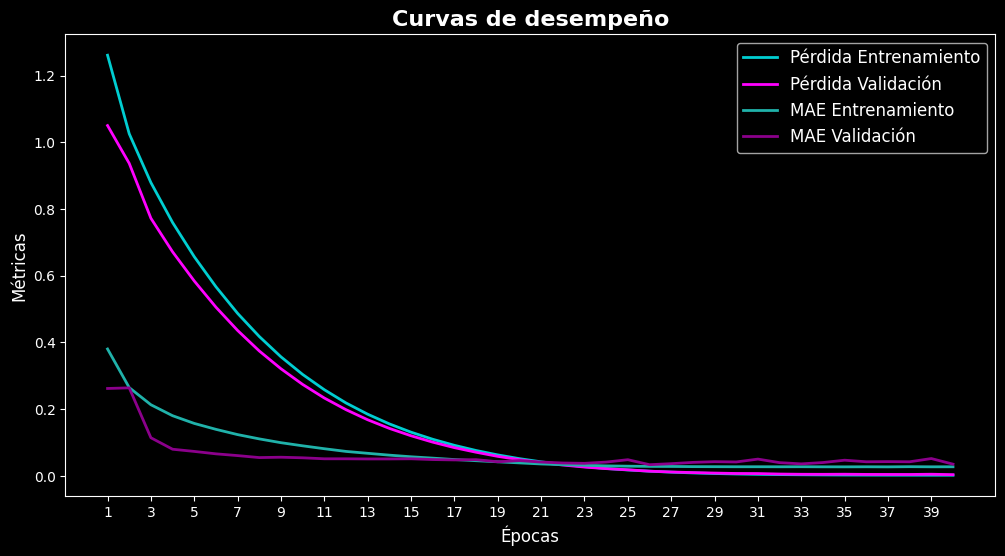

In [ ]:
#Gráfica de métricas

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(1, len(historial.history["loss"]) + 1), historial.history["loss"], label="Pérdida Entrenamiento",color='darkturquoise',linewidth=2)
plt.plot(range(1, len(historial.history["val_loss"]) + 1), historial.history["val_loss"], label="Pérdida Validación",color='magenta',linewidth=2)
plt.plot(range(1, len(historial.history["mae"]) + 1), historial.history["mae"], label="MAE Entrenamiento",color='lightseagreen',linewidth=2)
plt.plot(range(1, len(historial.history["val_mae"]) + 1), historial.history["val_mae"], label="MAE Validación", color='darkmagenta',linewidth=2)
plt.title("Curvas de desempeño", fontsize=16,fontweight='bold')
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Métricas", fontsize=12)
plt.xticks(range(1, 41, 2))
plt.legend(fontsize=12)
plt.show()

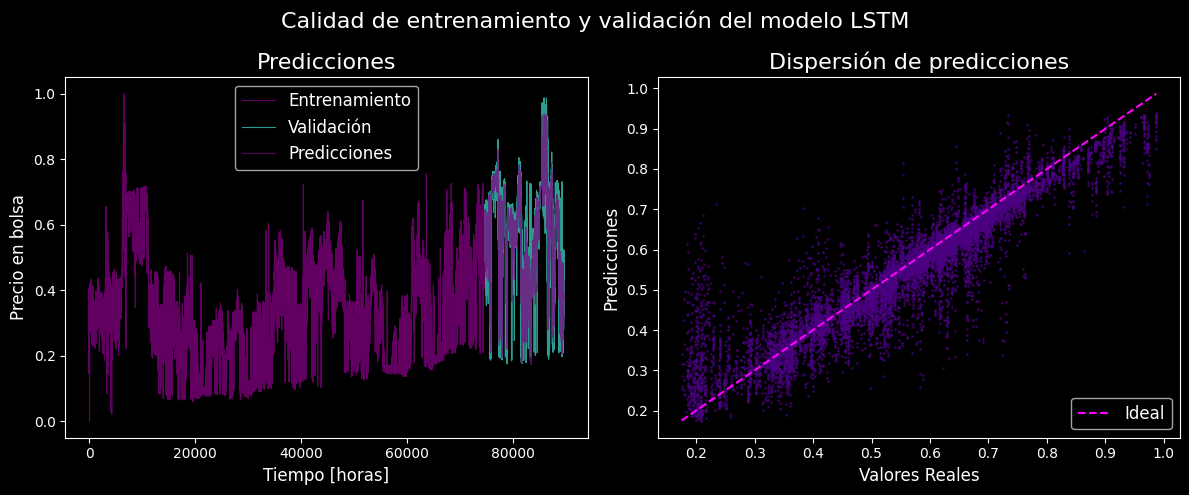

In [ ]:
#Calidad del entrenamiento

entreno = y_entreno.flatten()
val = y_val.flatten()
pred = y_pred.flatten()

xs = np.arange(len(entreno), len(entreno)+len(val), 1)

fig, axes = plt.subplots(1,2,figsize=(12,5))
fig.suptitle(f'Calidad de entrenamiento y validación del modelo LSTM',fontsize=16)

axes[0].plot(entreno, color="darkmagenta", alpha=0.7, linewidth=0.8, label='Entrenamiento')
axes[0].plot(xs, val, color="turquoise", alpha=0.7, linewidth=0.8, label='Validación')
axes[0].plot(xs, pred, color="purple", alpha=0.7, linewidth=0.8, label='Predicciones')
axes[0].set_xlabel("Tiempo [horas]",fontsize=12)
axes[0].set_ylabel("Precio en bolsa",fontsize=12)
axes[0].set_title("Predicciones",fontsize=16)
axes[0].legend(fontsize=12, loc='best')

#Dispersión de las predicciones
axes[1].scatter(y_val, y_pred, alpha=0.6, color="indigo", s=1)
axes[1].plot([val.min(), val.max()], [val.min(), val.max()], color="magenta", linestyle="--", label="Ideal")
# axes[1].plot(x,x,  c="red", linestyle="--", label="Ideal")
axes[1].set_xlabel("Valores Reales",fontsize=12)
axes[1].set_ylabel("Predicciones",fontsize=12)
axes[1].set_title("Dispersión de predicciones",fontsize=16)
axes[1].legend(fontsize=12, loc='lower right')

fig.tight_layout()

In [ ]:
#Predicciones
ventanas_futuras=48

escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(data.reshape(-1,1))
X_input = datos_escalados[-pasos_tiempo:].reshape(1, pasos_tiempo, 1)

predicciones = []

# Ventanas
for _ in range(ventanas_futuras):
  pred = modelo.predict(X_input, verbose=0)[0][0]
  predicciones.append(pred)

  X_input = np.append(X_input[:, 1:, :], [[[pred]]], axis=1)

# Invertir la transformación logarítmica y la normalización
predicciones = np.array(predicciones).reshape(-1, 1)
predicciones = escalador.inverse_transform(predicciones)
predicciones = np.exp(predicciones)

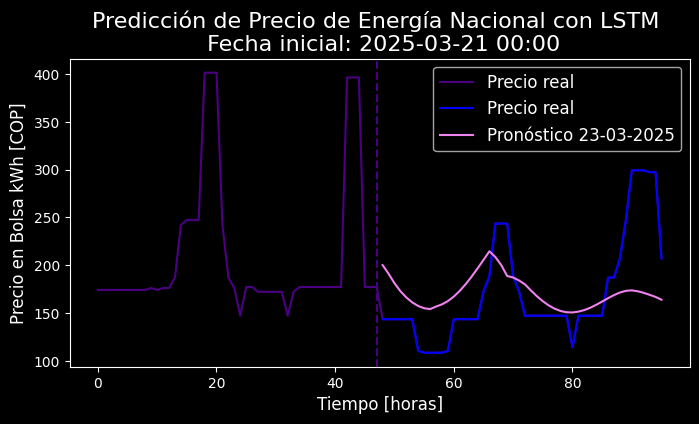

In [ ]:
#Serie real
datos_reales = df['precio_bolsa'][-48:].values

dias_atras=2

horas = np.arange(24*dias_atras, 24*dias_atras+48, 1)

datos_originales = df['precio_bolsa'].values

y_serie = df['precio_bolsa'][-48*dias_atras:]
fechas = y_serie.index.date

x = np.arange(0, 24*dias_atras, 1)
xs = np.arange(24*dias_atras, 24*dias_atras+ventanas_futuras, 1)

# Gráfico con predicciones
plt.figure(figsize=(8,4))
plt.plot(y_serie.values, label="Precio real", color='indigo')
plt.plot(horas, datos_reales, c='b', label='Precio real')
plt.axvline(x=24*dias_atras-1, color='indigo', linestyle='dashed')
plt.plot(xs, predicciones, color='violet', label="Pronóstico 23-03-2025")
plt.xlabel("Tiempo [horas]",fontsize=12)
plt.ylabel("Precio en Bolsa kWh [COP]",fontsize=12)
plt.title(f"Predicción de Precio de Energía Nacional con LSTM \n Fecha inicial: {fechas.min()} 00:00",fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Modelo LSTM para serie de tiempo multivariada

In [ ]:
df = pd.read_csv("/content/Data_MV.csv", sep=";", usecols=["Date", "Demanda_real", "Generacion_hidraulica", "Generacion_fosil", "Volumen_util", "Precio_bolsa"])


df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Transformación logarítmica y descomposición
df['log_precio_bolsa'] = np.log(df["Precio_bolsa"])

# Variables del modelo
data = df[['Demanda_real', 'Generacion_hidraulica', 'Generacion_fosil', 'Volumen_util', 'log_precio_bolsa']].values

In [ ]:
df = pd.read_csv("/content/Data_MV.csv", sep=";", usecols=["Date", "Demanda_real", "Generacion_hidraulica", "Generacion_fosil", "Volumen_util", "Precio_bolsa"])

df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

exclude_columns = ['Demanda_real', 'Generacion_hidraulica']

columns_to_transform = [col for col in df.columns if col not in exclude_columns and col != "Date"]

for column in columns_to_transform:
    df[column] = df[column].apply(lambda x: np.log(x) if x > 0 else np.nan)

print(f"Valores nulos en las columnas transformadas: \n{df[columns_to_transform].isnull().sum()}")

df = df.dropna(subset=columns_to_transform)

data = df[['Demanda_real', 'Generacion_hidraulica', 'Generacion_fosil', 'Volumen_util', 'Precio_bolsa']].values

print(df.head())

Valores nulos en las columnas transformadas: 
Generacion_fosil    0
Volumen_util        0
Precio_bolsa        0
dtype: int64
        Date  Demanda_real  Generacion_hidraulica  Generacion_fosil  \
0 2020-11-01        165.25                 138.65          3.504656   
1 2020-11-02        173.74                 144.41          3.495598   
2 2020-11-03        198.42                 159.84          3.779862   
3 2020-11-04        201.59                 164.50          3.843102   
4 2020-11-05        200.13                 155.29          3.943909   

   Volumen_util  Precio_bolsa  
0      9.365295      4.962215  
1      9.367589      5.279186  
2      9.368606      5.418320  
3      9.367652      5.329525  
4      9.368944      5.324813  


In [ ]:
data = data[:-7]

In [ ]:
# Modelo LSTM
pasos_tiempo = 7

# Generar secuencias de datos
def crear_secuencias(datos, pasos_tiempo):
    X, y = [], []
    for i in range(len(datos)-pasos_tiempo):
        X.append(datos[i:i+pasos_tiempo])
        y.append(datos[i+pasos_tiempo, -1])
    return np.array(X), np.array(y)

# Escalado de los datos
escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(data)

X, y = crear_secuencias(datos_escalados, pasos_tiempo)

tscv = TimeSeriesSplit(n_splits=5)

# Generar las divisiones
splits = list(tscv.split(X))

train_idx, test_idx = splits[-1]

X_entreno, X_val = X[train_idx], X[test_idx]
y_entreno, y_val = y[train_idx], y[test_idx]

# Red LSTM
modelo = Sequential([
    LSTM(28, return_sequences=True, activation="tanh", recurrent_activation="sigmoid", kernel_regularizer=l2(0.0179), input_shape=(pasos_tiempo, X.shape[2])),
    BatchNormalization(),
    Dropout(0.32),
    LSTM(28, return_sequences=False, activation="tanh", recurrent_activation="sigmoid", kernel_regularizer=l2(0.0179)),
    BatchNormalization(),
    Dropout(0.32),
    Dense(7, activation="tanh", kernel_regularizer=l2(0.0179)),
    Dense(1, activation="linear")
])


optimizador = Adam(learning_rate=0.00058)
modelo.compile(optimizer=optimizador, loss="mse", metrics=["mae"])

parada_temprana = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

historial = modelo.fit(X_entreno, y_entreno, epochs=40, batch_size=18, validation_data=(X_val, y_val), verbose=1, callbacks=[parada_temprana])

# Predicciones y métricas
y_pred = modelo.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Error absoluto medio (MAE): {mae:.6f}")
print(f"Coeficiente de determinación (R²): {r2:.6f}")

In [ ]:
modelo.summary()

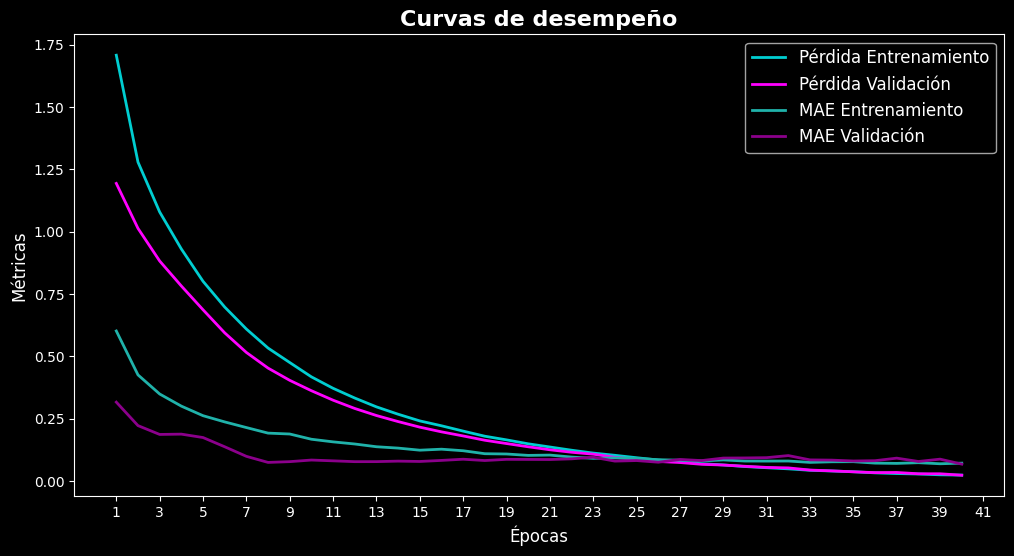

In [ ]:
#@title Gráfica de métricas

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(1, len(historial.history["loss"]) + 1), historial.history["loss"], label="Pérdida Entrenamiento",color='darkturquoise',linewidth=2)
plt.plot(range(1, len(historial.history["val_loss"]) + 1), historial.history["val_loss"], label="Pérdida Validación",color='magenta',linewidth=2)
plt.plot(range(1, len(historial.history["mae"]) + 1), historial.history["mae"], label="MAE Entrenamiento",color='lightseagreen',linewidth=2)
plt.plot(range(1, len(historial.history["val_mae"]) + 1), historial.history["val_mae"], label="MAE Validación", color='darkmagenta',linewidth=2)
plt.title("Curvas de desempeño",fontsize=16,fontweight='bold')
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("Métricas",fontsize=12)
plt.xticks(range(1, 43, 2))
plt.legend(fontsize=12)
plt.show()

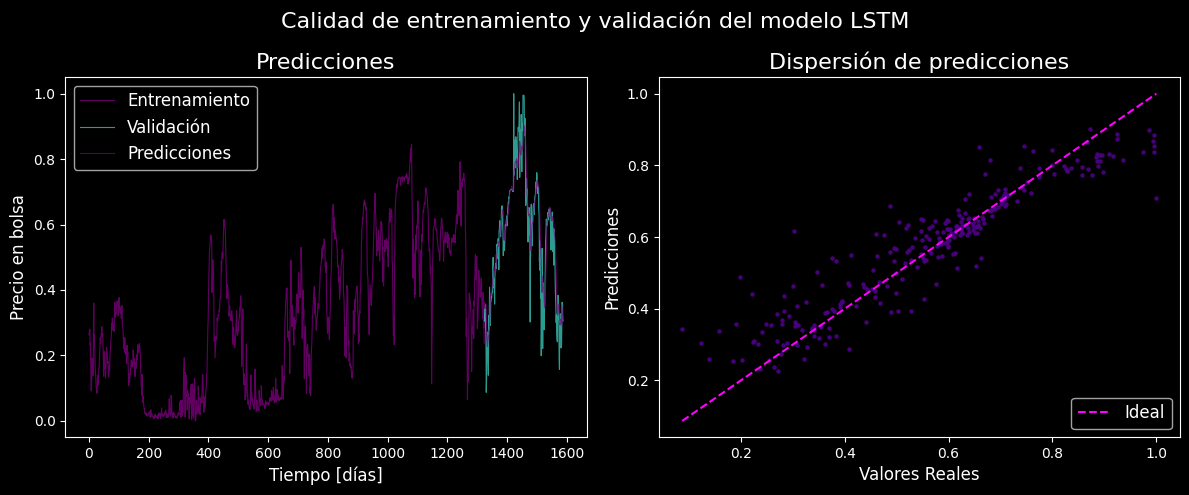

In [ ]:
#Calidad del entrenamiento

entreno = y_entreno.flatten()
val = y_val.flatten()
pred = y_pred.flatten()

xs = np.arange(len(entreno), len(entreno)+len(val), 1)

fig, axes = plt.subplots(1,2,figsize=(12,5))
fig.suptitle(f'Calidad de entrenamiento y validación del modelo LSTM',fontsize=16)

axes[0].plot(entreno, color="darkmagenta", alpha=0.7, linewidth=0.8, label='Entrenamiento')
axes[0].plot(xs, val, color="turquoise", alpha=0.7, linewidth=0.8, label='Validación')
axes[0].plot(xs, pred, color="purple", alpha=0.7, linewidth=0.8, label='Predicciones')
axes[0].set_xlabel("Tiempo [días]",fontsize=12)
axes[0].set_ylabel("Precio en bolsa",fontsize=12)
axes[0].set_title("Predicciones",fontsize=16)
axes[0].legend(fontsize=12, loc='best')

#Dispersión de las predicciones
axes[1].scatter(y_val, y_pred, alpha=0.9, color="indigo", s=5)
axes[1].plot([val.min(), val.max()], [val.min(), val.max()], color="magenta", linestyle="--", label="Ideal")
# axes[1].plot(x,x,  c="red", linestyle="--", label="Ideal")
axes[1].set_xlabel("Valores Reales",fontsize=12)
axes[1].set_ylabel("Predicciones",fontsize=12)
axes[1].set_title("Dispersión de predicciones",fontsize=16)
axes[1].legend(fontsize=12, loc='lower right')

fig.tight_layout()

In [ ]:
# Predicciones
ventanas_futuras = 7

X_input = datos_escalados[-pasos_tiempo:].reshape(1, pasos_tiempo, datos_escalados.shape[1])

predicciones = []

for _ in range(ventanas_futuras):
    # Predecir solo el precio de bolsa
    pred = modelo.predict(X_input, verbose=0)[0][0]
    predicciones.append(pred)


    X_input_updated = np.roll(X_input[0, :, :], -1, axis=0)
    X_input_updated[-1, -1] = pred
    X_input = X_input_updated.reshape(1, pasos_tiempo, datos_escalados.shape[1])

# Desescalar
predicciones = np.array(predicciones).reshape(-1, 1)
predicciones_a_desescalar = np.zeros((ventanas_futuras, datos_escalados.shape[1]))
predicciones_a_desescalar[:, -1] = predicciones[:, 0]

predicciones_desescaladas = escalador.inverse_transform(predicciones_a_desescalar)[:, -1]
predicciones_finales = np.exp(predicciones_desescaladas)



dias_atras = 7

y_serie = np.exp(df['Precio_bolsa'][-2*dias_atras:].values)
fechas = df[-(ventanas_futuras+dias_atras):]['Date'].dt.date

xs = np.arange(dias_atras, dias_atras + ventanas_futuras, 1)+8

# Gráfico con las predicciones
plt.figure(figsize=(8, 4))
plt.plot(range(8, 22), y_serie, label="Serie original", color='indigo')
plt.axvline(x=dias_atras+8, color='indigo', linestyle='dashed', label="Inicio Predicción: 2025-03-15")
plt.plot(xs, predicciones_finales, color='violet', label="Predicción")
plt.xlabel("Tiempo [días]",fontsize=12)
plt.ylabel("Precio en Bolsa [COP]",fontsize=12)
plt.title(f"Predicción de Precio de Energía con LSTM \n Fecha inicial: {fechas.min()}",fontsize=16)
plt.legend()
plt.show()



In [ ]:
# Predicciones
ventanas_futuras = 7

X_input = datos_escalados[-pasos_tiempo:].reshape(1, pasos_tiempo, datos_escalados.shape[1])

predicciones = []

for _ in range(ventanas_futuras):
    # Predecir solo el precio de bolsa
    pred = modelo.predict(X_input, verbose=0)[0][0]
    predicciones.append(pred)


    X_input_updated = np.roll(X_input[0, :, :], -1, axis=0)
    X_input_updated[-1, -1] = pred
    X_input = X_input_updated.reshape(1, pasos_tiempo, datos_escalados.shape[1])

# Desescalar
predicciones = np.array(predicciones).reshape(-1, 1)
predicciones_a_desescalar = np.zeros((ventanas_futuras, datos_escalados.shape[1]))
predicciones_a_desescalar[:, -1] = predicciones[:, 0]

predicciones_desescaladas = escalador.inverse_transform(predicciones_a_desescalar)[:, -1]
predicciones_finales = np.exp(predicciones_desescaladas)



dias_atras = 7

y_serie = np.exp(df['Precio_bolsa'][-2*dias_atras:].values)
fechas = df[-(ventanas_futuras+dias_atras):]['Date'].dt.date

xs = np.arange(dias_atras, dias_atras + ventanas_futuras, 1)+8

# Gráfico con las predicciones
plt.figure(figsize=(8, 4))
plt.plot(range(8, 22), y_serie, label="Serie original", color='indigo')
plt.axvline(x=dias_atras+8, color='indigo', linestyle='dashed', label="Inicio Predicción: 2025-03-15")
plt.plot(xs, predicciones_finales, color='violet', label="Predicción")
plt.xlabel("Tiempo [días]",fontsize=12)
plt.ylabel("Precio en Bolsa [COP]",fontsize=12)
plt.title(f"Predicción de Precio de Energía con LSTM \n Fecha inicial: {fechas.min()}",fontsize=16)
plt.legend()
plt.show()



**k-Folds**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

#Datos
df=pd.read_excel("/content/PBN.xlsx", usecols=["datetime","precio_bolsa"], sheet_name='2015')

df["datetime"]=pd.to_datetime(df["datetime"])

df.head()

# Gráficos de la serie de tiempo y sus componentes
plt.figure(figsize=(12,5))
plt.plot(df["datetime"], df["precio_bolsa"], label="Precio de Bolsa", color="darkmagenta", alpha=0.9, linewidth=0.1)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio de bolsa [kWh]", fontsize=12)
plt.title("Serie de tiempo Precio en bolsa del kWh", fontsize=16, fontweight='bold')
plt.show()

# Descomposición de la serie de tiempo
df.set_index("datetime", inplace=True)
decomposicion = sm.tsa.seasonal_decompose(df["precio_bolsa"], model="additive", period=24*30)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df["precio_bolsa"], label="Serie Original", color='magenta', linewidth=0.1)
axes[0].set_title("Serie de tiempo Original", fontsize=16)
axes[1].plot(decomposicion.trend, label="Tendencia", color="indigo", linewidth=1)
axes[1].set_title("Tendencia", fontsize=16)
axes[2].plot(decomposicion.seasonal, label="Estacionalidad", color="darkturquoise", linewidth=0.1)
axes[2].set_title("Estacionalidad", fontsize=16)
axes[3].plot(decomposicion.resid, label="Residuo", color="purple", linewidth=0.08)
axes[3].set_title("Residuo", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:


# Transformación logarítmica y descomposición
df['log_precio_bolsa'] = np.log(df["precio_bolsa"])  # Transformación de los datos
data = df['log_precio_bolsa'].values

# Gráfico de la serie logarítmica
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["log_precio_bolsa"], label="Logaritmo Precio en Bolsa", color="darkmagenta", alpha=0.9, linewidth=0.1)
plt.xlabel("Fecha")
plt.ylabel("ln(Precio kWh) [$]")
plt.title("Serie de tiempo Precio en bolsa del kWh")
plt.legend()
plt.show()

# Descomposición de la serie de tiempo
decomposicion = sm.tsa.seasonal_decompose(df["log_precio_bolsa"], model="additive", period=24*30)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df["log_precio_bolsa"], label="Serie Original", color='magenta', linewidth=0.1)
axes[0].set_title("Serie de tiempo Original")
axes[1].plot(decomposicion.trend, label="Tendencia", color="indigo", linewidth=1)
axes[1].set_title("Tendencia")
axes[2].plot(decomposicion.seasonal, label="Estacionalidad", color="darkturquoise", linewidth=0.08)
axes[2].set_title("Estacionalidad")
axes[3].plot(decomposicion.resid, label="Residuo", color="purple", linewidth=0.08)
axes[3].set_title("Residuo")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - loss: 1.6222 - mae: 0.5998 - val_loss: 1.0600 - val_mae: 0.1501
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 1.2989 - mae: 0.4107 - val_loss: 1.0145 - val_mae: 0.0949
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 1.1901 - mae: 0.3407 - val_loss: 0.9797 - val_mae: 0.0669
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.1184 - mae: 0.3029 - val_loss: 0.9548 - val_mae: 0.0979
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 1.0617 - mae: 0.2744 - val_loss: 0.9405 - val_mae: 0.1534
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 1.0147 - mae: 0.2556 - val_loss: 0.9174 - val_mae: 0.1679
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.9713 - mae: 0.2377 - val_loss: 0.8909 - val_mae: 0.1769
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.9330 - mae: 0.2275 - val_loss: 0.8526 - val_mae: 0.1477
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.8905 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 1.2883 - mae: 0.3566 - val_loss: 1.0594 - val_mae: 0.1637
Epoch 2/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - loss: 1.0963 - mae: 0.2452 - val_loss: 0.9609 - val_mae: 0.1296
Epoch 3/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.9882 - mae: 0.2043 - val_loss: 0.8703 - val_mae: 0.0780
Epoch 4/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.8981 - mae: 0.1798 - val_loss: 0.7936 - val_mae: 0.0525
Epoch 5/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.8164 - mae: 0.1612 - val_loss: 0.7270 - val_mae: 0.0642
Epoch 6/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.7410 - mae: 0.1451 - val_loss: 0.6624 - val_mae: 0.0611
Epoch 7/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.6728 - mae: 0.1342 - val_loss: 0.6014 - val_mae: 0.0509
Epoch 8/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.6088 - mae: 0.1216 - val_loss: 0.5456 - val_mae: 0.0467
Epoch 9/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 1.2898 - mae: 0.4051 - val_loss: 1.1970 - val_mae: 0.4667
Epoch 2/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 1.0365 - mae: 0.2612 - val_loss: 0.9723 - val_mae: 0.3354
Epoch 3/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.8882 - mae: 0.2105 - val_loss: 0.7666 - val_mae: 0.1450
Epoch 4/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.7640 - mae: 0.1751 - val_loss: 0.6769 - val_mae: 0.1481
Epoch 5/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.6571 - mae: 0.1487 - val_loss: 0.5805 - val_mae: 0.1181
Epoch 6/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.5645 - mae: 0.1292 - val_loss: 0.5031 - val_mae: 0.1113
Epoch 7/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.4849 - mae: 0.1158 - val_loss: 0.4235 - val_mae: 0.0736
Epoch 8/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.4154 - mae: 0.1045 - val_loss: 0.3582 - val_mae: 0.0455
Epoch 9/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/st

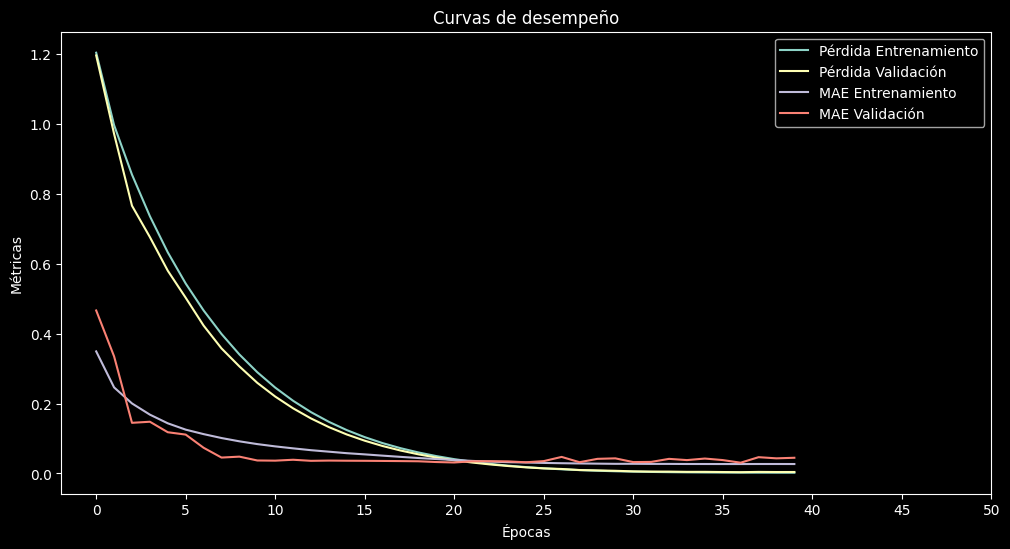

In [ ]:

# Modelo LSTM
data = df['log_precio_bolsa'][:-48].values

pasos_tiempo = 24

# Generar secuencias de datos
def crear_secuencias(datos, pasos_tiempo):
    X, y = [], []
    for i in range(len(datos)-pasos_tiempo):
        X.append(datos[i:i+pasos_tiempo])
        y.append(datos[i+pasos_tiempo])
    return np.array(X), np.array(y)

escalador = MinMaxScaler()
datos_escalados = escalador.fit_transform(data.reshape(-1, 1))

X, y = crear_secuencias(datos_escalados, pasos_tiempo)

# Validación cruzada con k-folds
tscv = TimeSeriesSplit(n_splits=3)
mse_list, mae_list, r2_list = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_entreno, X_val = X[train_idx], X[test_idx]
    y_entreno, y_val = y[train_idx], y[test_idx]

    # Red LSTM
    modelo = Sequential([
        LSTM(36, return_sequences=True, activation="tanh", recurrent_activation="sigmoid", kernel_regularizer=l2(0.012), input_shape=(pasos_tiempo, 1)),
        BatchNormalization(),
        Dropout(0.23),
        LSTM(36, return_sequences=False, activation="tanh", recurrent_activation="sigmoid", kernel_regularizer=l2(0.012)),
        BatchNormalization(),
        Dropout(0.23),
        Dense(24, activation="tanh", kernel_regularizer=l2(0.012)),
        Dense(1, activation="linear")
    ])

    optimizador = Adam(learning_rate=0.00005)
    modelo.compile(optimizer=optimizador, loss="mse", metrics=["mae"])

    parada_temprana = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    historial = modelo.fit(X_entreno, y_entreno, epochs=40, batch_size=256, validation_data=(X_val, y_val), verbose=1, callbacks=[parada_temprana])

    # Predicciones y métricas
    y_pred = modelo.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Promedio de las métricas de la validación cruzada
print(f"Error cuadrático medio (MSE) Promedio: {np.mean(mse_list):.6f}")
print(f"Error absoluto medio (MAE) Promedio: {np.mean(mae_list):.6f}")
print(f"Coeficiente de determinación (R²) Promedio: {np.mean(r2_list):.6f}")

# Gráfica de las métricas
plt.figure(figsize=(12, 6))
plt.plot(historial.history["loss"], label="Pérdida Entrenamiento")
plt.plot(historial.history["val_loss"], label="Pérdida Validación")
plt.plot(historial.history["mae"], label="MAE Entrenamiento")
plt.plot(historial.history["val_mae"], label="MAE Validación")
plt.title("Curvas de desempeño")
plt.xlabel("Épocas")
plt.ylabel("Métricas")
plt.xticks(range(0, 51, 5))
plt.legend()
plt.show()

Error cuadrático medio (MSE) Promedio: 0.001971
Error absoluto medio (MAE) Promedio: 0.027687
Coeficiente de determinación (R²) Promedio: 0.904349


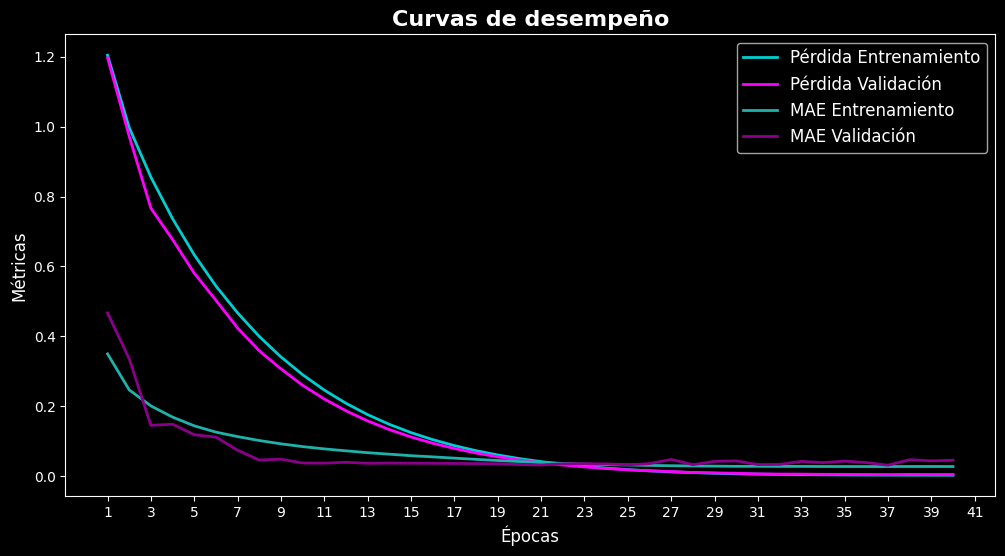

In [ ]:
# Promediar las métricas de la validación cruzada
print(f"Error cuadrático medio (MSE) Promedio: {np.mean(mse_list):.6f}")
print(f"Error absoluto medio (MAE) Promedio: {np.mean(mae_list):.6f}")
print(f"Coeficiente de determinación (R²) Promedio: {np.mean(r2_list):.6f}")

# Gráfica de las métricas
plt.figure(figsize=(12,6))
plt.plot(range(1, len(historial.history["loss"]) + 1), historial.history["loss"], label="Pérdida Entrenamiento",color='darkturquoise',linewidth=2)
plt.plot(range(1, len(historial.history["val_loss"]) + 1), historial.history["val_loss"], label="Pérdida Validación",color='magenta',linewidth=2)
plt.plot(range(1, len(historial.history["mae"]) + 1), historial.history["mae"], label="MAE Entrenamiento",color='lightseagreen',linewidth=2)
plt.plot(range(1, len(historial.history["val_mae"]) + 1), historial.history["val_mae"], label="MAE Validación", color='darkmagenta',linewidth=2)
plt.title("Curvas de desempeño",fontsize=16,fontweight='bold')
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("Métricas",fontsize=12)
plt.xticks(range(1, 43, 2))
plt.legend(fontsize=12)
plt.show()